# HFF Water Quality

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, OrdinalEncoder, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV


from statsmodels.tsa.stattools import adfuller

In [2]:
def display_df(dftest):
    '''
    Display the output from a Dickey-Fuller test in a more readable format
    '''
    
    
    dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    display(dfoutput)

Notes from Senior Scientist, Rob Van Kirk:

Looks like two daily time series files are all you will need, once you put the water quality 15-minute data into daily time series format. Those two files are attached. The hydrology file is "IslandPark.TS.csv". The relevant columns for you are:
 
smoothed.elev           End-of-day (midnight) elevation in acre-feet--but maybe the next variable is better (thinking on the fly)

surfacearea.acres      End-of-day surface area of the reservoir in acres (subtract this from 8000 and you will get acres of exposed reservoir bottom--just thought of that)

delta.V.af                    Daily change in reservoir volume (acre-feet). If positive, reservoir is filling; if negative it's drafting

regQ.cfs                     Average daily reservoir outflow (cfs)

smoothed.nat.Q.cfs   Natural streamflow at the dam (cfs). This is not exactly the same as inflow, but it's close and is the streamflow that would be in the river in absence of Island Park Dam and Henry's Lake Dam. The storage/delivery at Henry's Lake is why this isn't exactly the same as inflow to Island Park, but this does represent natural watershed runoff. The effect of storage/delivery at Henry's Lake is small compared to the natural watershed processes. 


The climate data are in Clean.Climate.TS.csv. The attached text file gives you a guide to the column names, although the file itself is specific to the water-year format files. The three relevant stations are:


CC     Crab Creek SnoTel station, which is an indicator of conditions in tributaries that feed the west end of IP Reservoir

IP       Island Park SnoTel station, located one-half mile from the dam.

WE    White Elephant SnoTel station, located on the side of Mt. Sawtelle. It indicates conditions in the Henry's Lake/Mack's Inn area.



Summary:

Response variable is turbidity at our IPE water quality station.

Potential predictors/correlates:


Precipitation and snowmelt at the SnoTel stations

Turbidity at FR (Flat Rock) water quality station

chlorophyll and cyanobacteria indices at IPE (can't remember the column names right offhand; should be apparent)

Reservoir elevation

Exposed reservoir shoreline area (8000 - surface area)

Reservoir outflow

Natural flow at IP

In [3]:
ipe_df = pd.read_csv('data/15_min_data_HFF/IPE 15 min 2022-08-08.csv')
ipe_df

,contTime,Turb_FNU,TurbDailyMn,TurbSamp_NTU,Chloro_RFU,ChloroDailyMn,BGA_RFU,BGADailyMn,ODO_mgL,ODODailyMn,...,Temp_C_raw,Cond_muSCm_raw,TDS_mgL_raw,TotalPres_psi_raw,Turb_avdymn,Chlor_avdymn,Cyano_avdymn,Temp_avdymn,ODO_avdymn,Cond_avdymn
0,2014-06-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-06-20 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-06-20 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-06-20 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-06-20 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285217,2022-08-07 23:00:00,5.48,NaN,NaN,0.34,NaN,0.02,NaN,7.49,NaN,...,18.66,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285218,2022-08-07 23:15:00,5.74,NaN,NaN,0.27,NaN,0.03,NaN,7.48,NaN,...,18.64,123.5,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285219,2022-08-07 23:30:00,6.37,NaN,NaN,0.29,NaN,0.03,NaN,7.47,NaN,...,18.64,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285220,2022-08-07 23:45:00,6.40,NaN,NaN,0.34,NaN,0.02,NaN,7.48,NaN,...,18.63,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
ipe_df['contTime'] = pd.to_datetime(ipe_df['contTime'])
ipe_df.set_index(['contTime'], inplace=True)
ipe_df.index.names = ['date']
ipe_df

,Turb_FNU,TurbDailyMn,TurbSamp_NTU,Chloro_RFU,ChloroDailyMn,BGA_RFU,BGADailyMn,ODO_mgL,ODODailyMn,Temp_C,...,Temp_C_raw,Cond_muSCm_raw,TDS_mgL_raw,TotalPres_psi_raw,Turb_avdymn,Chlor_avdymn,Cyano_avdymn,Temp_avdymn,ODO_avdymn,Cond_avdymn
date,,,,,,,,,,,,,,,,,,,,,
2014-06-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-20 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-20 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-20 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-20 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-07 23:00:00,5.48,NaN,NaN,0.34,NaN,0.02,NaN,7.49,NaN,18.66,...,18.66,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-07 23:15:00,5.74,NaN,NaN,0.27,NaN,0.03,NaN,7.48,NaN,18.64,...,18.64,123.5,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-07 23:30:00,6.37,NaN,NaN,0.29,NaN,0.03,NaN,7.47,NaN,18.64,...,18.64,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
ipe_daily = ipe_df.resample('D').mean()

In [6]:
ipe_daily = ipe_daily[:'2022-08-01']

In [7]:
ipe_daily

,Turb_FNU,TurbDailyMn,TurbSamp_NTU,Chloro_RFU,ChloroDailyMn,BGA_RFU,BGADailyMn,ODO_mgL,ODODailyMn,Temp_C,...,Temp_C_raw,Cond_muSCm_raw,TDS_mgL_raw,TotalPres_psi_raw,Turb_avdymn,Chlor_avdymn,Cyano_avdymn,Temp_avdymn,ODO_avdymn,Cond_avdymn
date,,,,,,,,,,,,,,,,,,,,,
2014-06-20,2.282571,NaN,2.883333,0.343889,NaN,-0.009167,NaN,6.402500,NaN,13.020333,...,13.020333,98.772222,83.000000,11.642306,2.948023,0.603837,0.102474,13.602552,7.434667,119.362484
2014-06-21,2.491979,2.487097,NaN,0.366667,0.367527,-0.003125,-0.002581,6.491563,6.511828,12.617740,...,12.617740,97.936458,83.302083,11.666146,3.087716,0.643661,0.112450,13.759623,7.438532,119.774590
2014-06-22,2.760521,2.760521,NaN,0.370417,0.370417,-0.002396,-0.002396,6.799479,6.799479,12.587917,...,12.587917,98.336458,83.875000,11.690604,3.302915,0.710180,0.154355,13.946474,7.471170,120.355465
2014-06-23,3.366875,3.366875,4.056667,0.427187,0.427187,0.011667,0.011667,6.973333,6.973333,12.869354,...,12.869354,100.618750,85.187500,11.717281,3.678330,0.552335,0.076311,13.898306,7.783264,119.795716
2014-06-24,4.185000,4.185000,NaN,0.578438,0.578438,0.051042,0.051042,6.847812,6.847812,12.998385,...,12.998385,104.945833,88.541667,11.707031,3.881812,0.502070,0.072871,14.001303,7.923084,121.559347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-28,4.219896,4.219896,NaN,0.428229,0.428229,0.047188,0.047188,6.822292,6.822292,19.556458,...,19.556458,156.690625,0.110000,13.335000,3.351399,0.329851,0.105151,18.231818,6.663407,147.675620
2022-07-29,3.899583,3.899583,NaN,0.438333,0.438333,0.048646,0.048646,6.774479,6.774479,19.535104,...,19.535104,157.709375,0.110000,13.340729,3.625946,0.314202,0.068919,18.155853,6.629087,147.180402
2022-07-30,3.379583,3.379583,NaN,0.413229,0.413229,0.047708,0.047708,6.654688,6.654687,19.576562,...,19.576562,158.085417,0.110000,13.353229,3.899483,0.320148,0.051110,18.024200,6.586092,146.751797


<AxesSubplot:xlabel='date'>

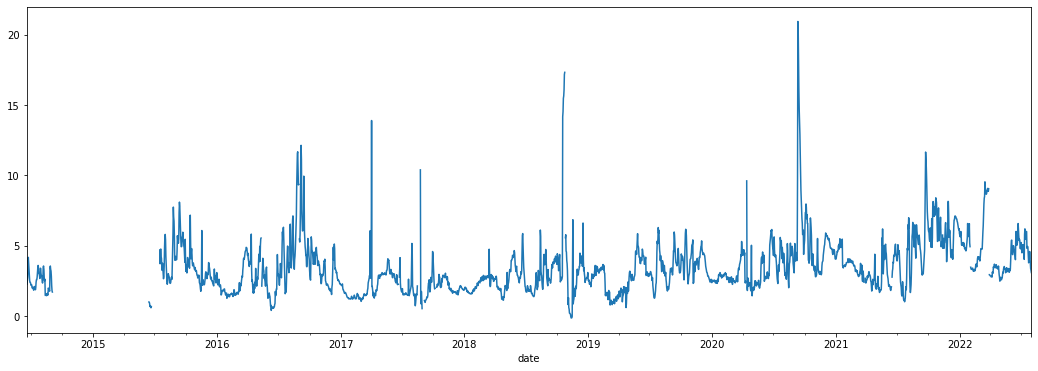

In [8]:
ipe_daily['Turb_FNU'].plot(figsize=(18,6))

In [9]:
ipe_daily.isna().sum()

Turb_FNU              348
TurbDailyMn           349
TurbSamp_NTU         2670
Chloro_RFU            355
ChloroDailyMn         356
BGA_RFU               353
BGADailyMn            354
ODO_mgL               193
ODODailyMn            194
Temp_C                191
TempDailyMn           192
Cond_muSCm            191
CondDailyMn           192
TDS_mgL               191
TotalPres_psi         191
AshtonAirPres_psi    1697
Depth_ft             1742
Shift_psi             161
Turb_FNU_raw          191
Chloro_RFU_raw        191
BGA_RFU_raw           191
ODO_mgL_raw           191
Temp_C_raw            191
Cond_muSCm_raw        191
TDS_mgL_raw           191
TotalPres_psi_raw     191
Turb_avdymn             0
Chlor_avdymn            0
Cyano_avdymn            0
Temp_avdymn             0
ODO_avdymn              0
Cond_avdymn             0
dtype: int64

In [10]:
ipe_daily.columns

Index(['Turb_FNU', 'TurbDailyMn', 'TurbSamp_NTU', 'Chloro_RFU',
       'ChloroDailyMn', 'BGA_RFU', 'BGADailyMn', 'ODO_mgL', 'ODODailyMn',
       'Temp_C', 'TempDailyMn', 'Cond_muSCm', 'CondDailyMn', 'TDS_mgL',
       'TotalPres_psi', 'AshtonAirPres_psi', 'Depth_ft', 'Shift_psi',
       'Turb_FNU_raw', 'Chloro_RFU_raw', 'BGA_RFU_raw', 'ODO_mgL_raw',
       'Temp_C_raw', 'Cond_muSCm_raw', 'TDS_mgL_raw', 'TotalPres_psi_raw',
       'Turb_avdymn', 'Chlor_avdymn', 'Cyano_avdymn', 'Temp_avdymn',
       'ODO_avdymn', 'Cond_avdymn'],
      dtype='object')

In [11]:
ipe_daily.drop(['TurbDailyMn', 'TurbSamp_NTU',
       'ChloroDailyMn', 'BGADailyMn', 'ODODailyMn',
       'TempDailyMn', 'CondDailyMn', 'TDS_mgL',
       'TotalPres_psi', 'AshtonAirPres_psi', 'Depth_ft', 'Shift_psi',
       'Turb_FNU_raw', 'Chloro_RFU_raw', 'BGA_RFU_raw', 'ODO_mgL_raw',
       'Temp_C_raw', 'Cond_muSCm_raw', 'TDS_mgL_raw', 'TotalPres_psi_raw',
       'Turb_avdymn', 'Chlor_avdymn', 'Cyano_avdymn', 'Temp_avdymn',
       'ODO_avdymn', 'Cond_avdymn'], axis=1, inplace=True)

In [12]:
ipe_interp = ipe_daily.interpolate(method='spline', order=2)

In [13]:
ipe_interp.columns

Index(['Turb_FNU', 'Chloro_RFU', 'BGA_RFU', 'ODO_mgL', 'Temp_C', 'Cond_muSCm'], dtype='object')

In [14]:
ipe_interp.isna().sum()

Turb_FNU      0
Chloro_RFU    0
BGA_RFU       0
ODO_mgL       0
Temp_C        0
Cond_muSCm    0
dtype: int64

In [15]:
ipe_interp.dropna(inplace=True)

<AxesSubplot:xlabel='date'>

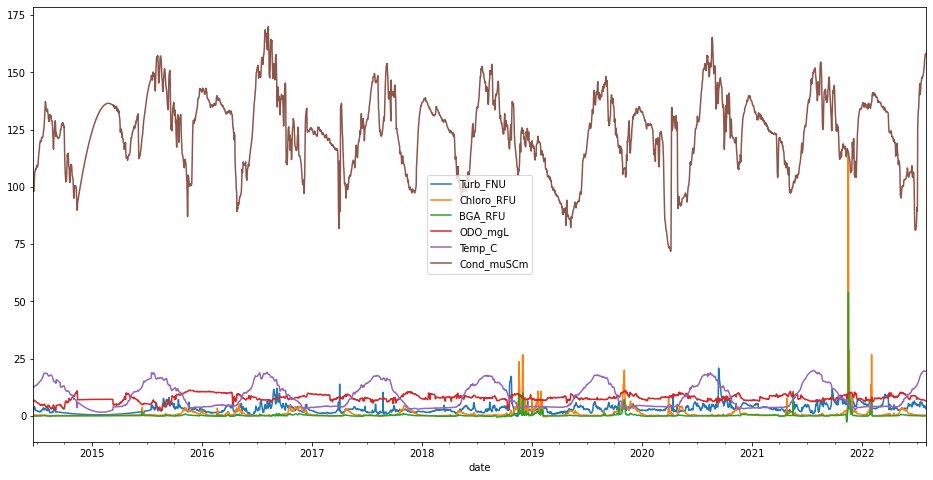

In [16]:
ipe_interp.plot(figsize=(16,8))

In [17]:
ipe_interp.corr()

,Turb_FNU,Chloro_RFU,BGA_RFU,ODO_mgL,Temp_C,Cond_muSCm
Turb_FNU,1.000000,0.067030,0.056656,-0.006336,0.167472,0.165159
Chloro_RFU,0.067030,1.000000,0.818723,0.170658,-0.133997,-0.136910
BGA_RFU,0.056656,0.818723,1.000000,0.109305,-0.107831,-0.077103
ODO_mgL,-0.006336,0.170658,0.109305,1.000000,-0.484297,-0.356563
Temp_C,0.167472,-0.133997,-0.107831,-0.484297,1.000000,0.455672
Cond_muSCm,0.165159,-0.136910,-0.077103,-0.356563,0.455672,1.000000


In [18]:
# import island park dam hydrology data
hydro_df = pd.read_csv('data/IslandPark.TS.csv')

# set the datetime to the index
hydro_df['date'] = pd.to_datetime(hydro_df['date'])
hydro_df.set_index(['date'], inplace=True)
hydro_df.index.names = ['date']
hydro_df.columns

Index(['elevation.ft', 'volume.af', 'smoothed.vol', 'smoothed.elev',
       'surfacearea.acres', 'net.evap.af', 'delta.V.af', 'regQ.cfs',
       'gain.cfs', 'smoothed.natQ.cfs'],
      dtype='object')

Key:



In [19]:
# set the range of the data to the same as the sonde data
hydro_df = hydro_df['2014-06-20':'2022-08-01']

In [20]:
# interpolate NaN values
hydro_interp = hydro_df.interpolate(method='spline', order=2)

In [21]:
# calculate exposed shoreline
hydro_interp['exposed_shore'] = 8000 - hydro_interp['surfacearea.acres']

In [22]:
# drop redundant columns
hydro_interp.drop(['volume.af', 'smoothed.vol', 
                   'smoothed.elev', 'surfacearea.acres'], axis=1, inplace=True)

In [23]:
hydro_interp

,elevation.ft,net.evap.af,delta.V.af,regQ.cfs,gain.cfs,smoothed.natQ.cfs,exposed_shore
date,,,,,,,
2014-06-20,6302.410000,45.963939,157.885714,476.000000,512.621037,591.405028,729.401350
2014-06-21,6302.430000,47.815575,191.828571,459.000000,513.032397,599.594050,726.007579
2014-06-22,6302.490000,45.131249,157.814286,449.000000,483.831078,601.354315,722.633683
2014-06-23,6302.460000,49.711959,112.714286,459.000000,473.033457,586.847675,720.035333
2014-06-24,6302.510000,50.669190,238.342857,448.000000,525.632347,582.186314,716.696884
...,...,...,...,...,...,...,...
2022-07-28,6297.244536,45.817345,-1345.832163,1182.187500,407.214395,442.453386,1888.767601
2022-07-29,6297.048306,45.452590,-1304.151495,1181.875000,429.932614,451.777714,1946.610070
2022-07-30,6296.847349,45.092242,-1262.938888,1183.750000,454.622985,465.082169,2003.672122


<AxesSubplot:xlabel='date'>

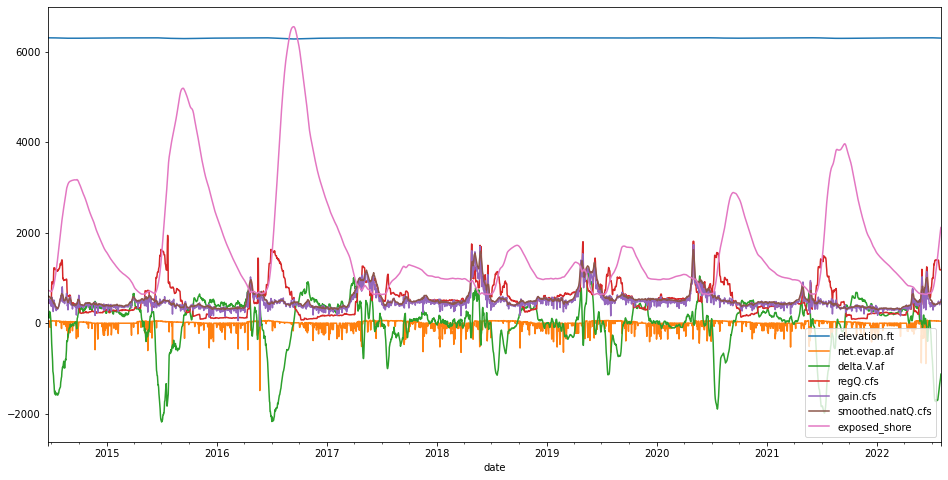

In [24]:
hydro_interp.plot(figsize=(16,8))

In [25]:
climate_df = pd.read_csv('data/Clean.Climate.TS.csv')
climate_df['Date'] = pd.to_datetime(climate_df['Date'])
climate_df.set_index(['Date'], inplace=True)
climate_df.drop(['GT.TAVE', 'GT.TMIN', 'GT.TMAX', 'GT.DP', 'GT.AP', 'GT.SWE', 'PB.TAVE',
       'PB.TMIN', 'PB.TMAX', 'PB.DP','HFW.AP', 'TR.SWE', 'FR.SWE', 'HF.SWE', 'HFW.SWE', 'AG.DP', 'AG.ET',
       'HFW.Cum.P', 'AG.Cum.P', 'AG.Cum.ET', 'PB.AP', 'PB.SWE', 'BB.TAVE', 'BB.TMIN', 'BB.TMAX', 'BB.DP', 'BB.AP',
       'BB.SWE', 'LL.TAVE', 'LL.TMIN', 'LL.TMAX', 'LL.DP', 'LL.AP', 'LL.SWE', 'GL.TAVE',
       'GL.TMIN', 'GL.TMAX', 'GL.DP', 'GL.AP', 'GL.SWE', 'PC.TAVE', 'PC.TMIN', 'PC.TMAX',
       'PC.DP', 'PC.AP', 'PC.SWE', 'AL.TAVE', 'AL.TMIN', 'AL.TMAX', 'AL.DP', 'AL.AP',
       'AS.TAVE', 'AS.TMIN', 'AS.TMAX', 'AS.DP', 'AS.AP', 'AS.ET', 'RX.TAVE',
       'RX.TMIN', 'RX.TMAX', 'RX.DP', 'RX.AP', 'RX.ET', 'TR.TAVE', 'FR.TAVE',
       'HF.TAVE', 'VA.TAVE', 'HFW.TAVE', 'TR.TMIN', 'FR.TMIN', 'HF.TMIN',
       'VA.TMIN', 'HFW.TMIN', 'TR.TMAX', 'FR.TMAX', 'HF.TMAX', 'VA.TMAX',
       'HFW.TMAX', 'TR.DP', 'FR.DP', 'HF.DP', 'VA.DP', 'HFW.DP', 'TR.AP',
       'FR.AP', 'HF.AP', 'VA.AP', 'WE.TMIN', 'WE.TMAX', 'CC.TMIN', 'CC.TMAX',
       'IP.TMIN', 'IP.TMAX'], axis=1, inplace=True)
climate_df.index.names = ['date']
climate_df.columns

Index(['WE.TAVE', 'WE.DP', 'WE.AP', 'WE.SWE', 'CC.TAVE', 'CC.DP', 'CC.AP',
       'CC.SWE', 'IP.TAVE', 'IP.DP', 'IP.AP', 'IP.SWE'],
      dtype='object')

In [26]:
climate_df = climate_df['2014-06-20':'2022-08-01']

In [27]:
clim_interp = climate_df.interpolate(method='spline', order=2)

Key:

TAVE = Air temperature average (F)

SWE = Snow water equivalent (inches)

In [28]:
clim_interp.isna().sum()

WE.TAVE    0
WE.DP      0
WE.AP      0
WE.SWE     0
CC.TAVE    0
CC.DP      0
CC.AP      0
CC.SWE     0
IP.TAVE    0
IP.DP      0
IP.AP      0
IP.SWE     0
dtype: int64

<AxesSubplot:xlabel='date'>

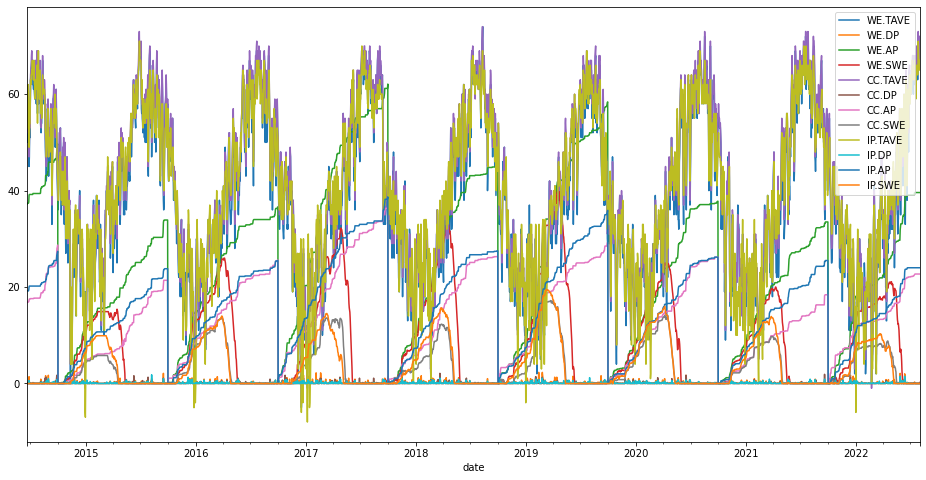

In [29]:
clim_interp.plot(figsize=(16,8))

In [30]:
clim_interp

,WE.TAVE,WE.DP,WE.AP,WE.SWE,CC.TAVE,CC.DP,CC.AP,CC.SWE,IP.TAVE,IP.DP,IP.AP,IP.SWE
date,,,,,,,,,,,,
2014-06-20,56.0,0.0,37.2,0.0,58.0,0.1,16.8,0.0,58.0,0.0,19.2,0.0
2014-06-21,55.0,0.0,37.2,0.0,58.0,0.0,16.8,0.0,58.0,0.0,19.2,0.0
2014-06-22,50.0,0.2,37.4,0.0,52.0,0.0,16.8,0.0,53.0,0.0,19.2,0.0
2014-06-23,54.0,0.0,37.4,0.0,56.0,0.1,16.9,0.0,58.0,0.0,19.2,0.0
2014-06-24,58.0,0.0,37.4,0.0,60.0,0.0,16.9,0.0,62.0,0.0,19.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-28,67.0,0.0,39.6,0.0,68.0,0.0,22.7,0.0,69.0,0.0,24.0,0.0
2022-07-29,66.0,0.0,39.6,0.0,67.0,0.0,22.7,0.0,66.0,0.0,24.0,0.0
2022-07-30,69.0,0.0,39.6,0.0,70.0,0.0,22.7,0.0,66.0,0.0,24.0,0.0


In [31]:
final_df = pd.merge(clim_interp, hydro_interp, on=['date'])
final_df = pd.merge(final_df, ipe_interp, on=['date'])

In [32]:
final_df.isna().sum()

WE.TAVE              0
WE.DP                0
WE.AP                0
WE.SWE               0
CC.TAVE              0
CC.DP                0
CC.AP                0
CC.SWE               0
IP.TAVE              0
IP.DP                0
IP.AP                0
IP.SWE               0
elevation.ft         0
net.evap.af          0
delta.V.af           0
regQ.cfs             0
gain.cfs             0
smoothed.natQ.cfs    0
exposed_shore        0
Turb_FNU             0
Chloro_RFU           0
BGA_RFU              0
ODO_mgL              0
Temp_C               0
Cond_muSCm           0
dtype: int64

In [33]:
final_df


,WE.TAVE,WE.DP,WE.AP,WE.SWE,CC.TAVE,CC.DP,CC.AP,CC.SWE,IP.TAVE,IP.DP,...,regQ.cfs,gain.cfs,smoothed.natQ.cfs,exposed_shore,Turb_FNU,Chloro_RFU,BGA_RFU,ODO_mgL,Temp_C,Cond_muSCm
date,,,,,,,,,,,,,,,,,,,,,
2014-06-20,56.0,0.0,37.2,0.0,58.0,0.1,16.8,0.0,58.0,0.0,...,476.000000,512.621037,591.405028,729.401350,2.282571,0.343889,-0.009167,6.402500,13.020333,98.772222
2014-06-21,55.0,0.0,37.2,0.0,58.0,0.0,16.8,0.0,58.0,0.0,...,459.000000,513.032397,599.594050,726.007579,2.491979,0.366667,-0.003125,6.491563,12.617740,97.936458
2014-06-22,50.0,0.2,37.4,0.0,52.0,0.0,16.8,0.0,53.0,0.0,...,449.000000,483.831078,601.354315,722.633683,2.760521,0.370417,-0.002396,6.799479,12.587917,98.336458
2014-06-23,54.0,0.0,37.4,0.0,56.0,0.1,16.9,0.0,58.0,0.0,...,459.000000,473.033457,586.847675,720.035333,3.366875,0.427187,0.011667,6.973333,12.869354,100.618750
2014-06-24,58.0,0.0,37.4,0.0,60.0,0.0,16.9,0.0,62.0,0.0,...,448.000000,525.632347,582.186314,716.696884,4.185000,0.578438,0.051042,6.847812,12.998385,104.945833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-28,67.0,0.0,39.6,0.0,68.0,0.0,22.7,0.0,69.0,0.0,...,1182.187500,407.214395,442.453386,1888.767601,4.219896,0.428229,0.047188,6.822292,19.556458,156.690625
2022-07-29,66.0,0.0,39.6,0.0,67.0,0.0,22.7,0.0,66.0,0.0,...,1181.875000,429.932614,451.777714,1946.610070,3.899583,0.438333,0.048646,6.774479,19.535104,157.709375
2022-07-30,69.0,0.0,39.6,0.0,70.0,0.0,22.7,0.0,66.0,0.0,...,1183.750000,454.622985,465.082169,2003.672122,3.379583,0.413229,0.047708,6.654688,19.576562,158.085417


In [34]:
# verify that the merge did not create any NaN values
final_df.isna().sum()

WE.TAVE              0
WE.DP                0
WE.AP                0
WE.SWE               0
CC.TAVE              0
CC.DP                0
CC.AP                0
CC.SWE               0
IP.TAVE              0
IP.DP                0
IP.AP                0
IP.SWE               0
elevation.ft         0
net.evap.af          0
delta.V.af           0
regQ.cfs             0
gain.cfs             0
smoothed.natQ.cfs    0
exposed_shore        0
Turb_FNU             0
Chloro_RFU           0
BGA_RFU              0
ODO_mgL              0
Temp_C               0
Cond_muSCm           0
dtype: int64

In [73]:
final_df = final_df['2016':'2020']

In [77]:
display_df(adfuller(final_df['Turb_FNU']))

Test Statistic                -7.197787e+00
p-value                        2.409241e-10
#Lags Used                     8.000000e+00
Number of Observations Used    1.818000e+03
Critical Value (1%)           -3.433952e+00
Critical Value (5%)           -2.863131e+00
Critical Value (10%)          -2.567617e+00
dtype: float64

<AxesSubplot:xlabel='date'>

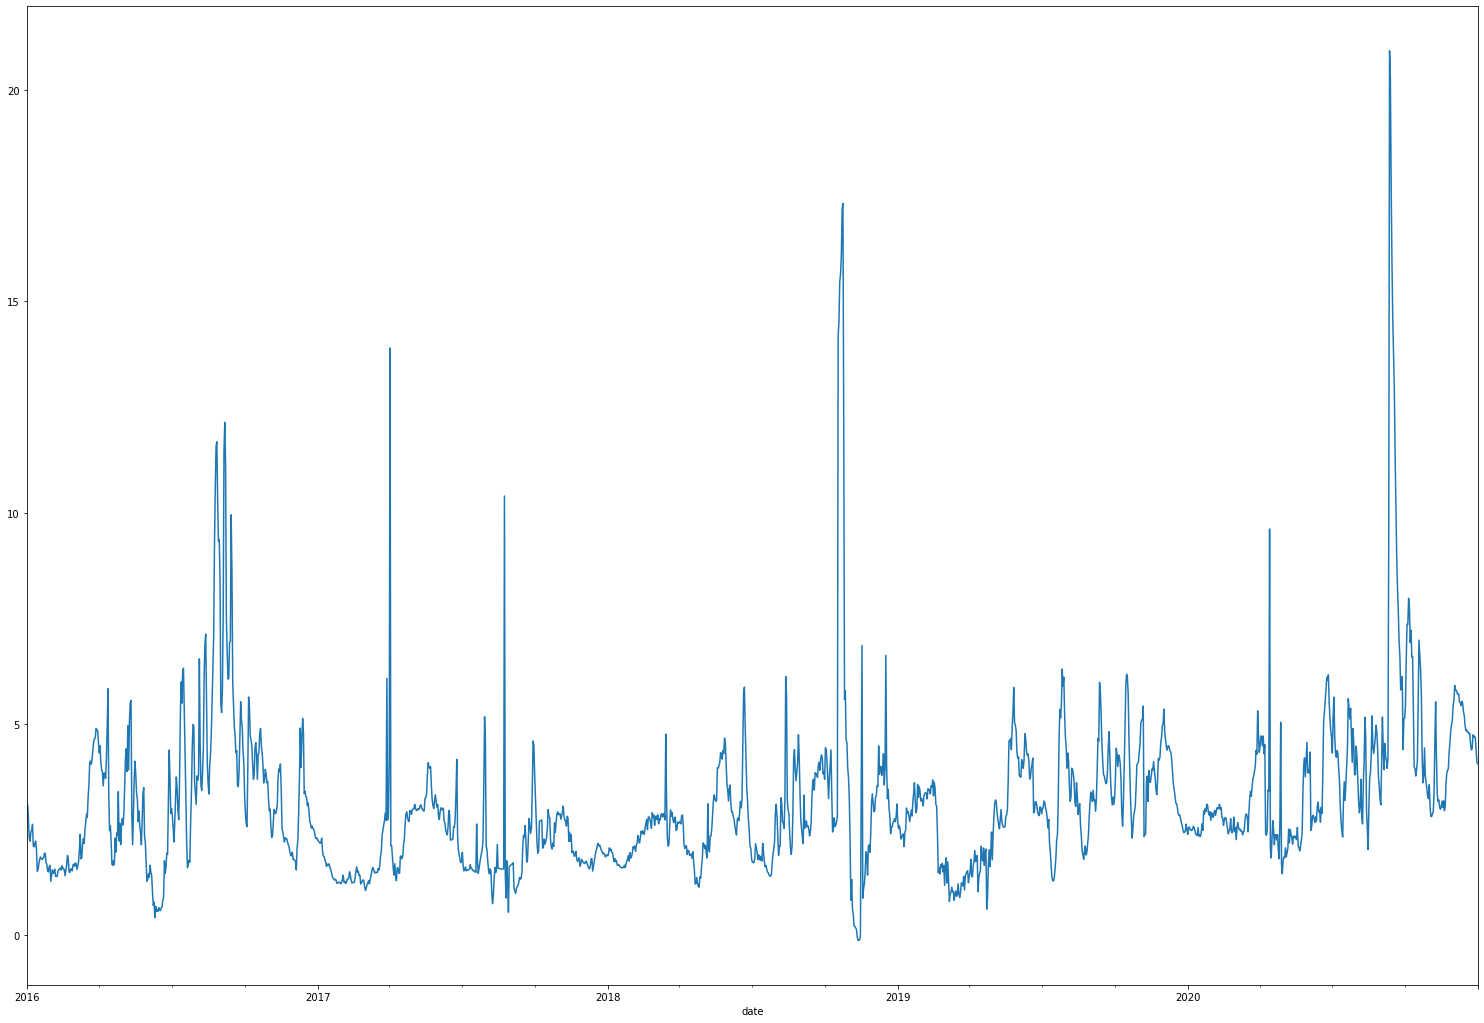

In [74]:
final_df['Turb_FNU'].plot(figsize=(26,18))

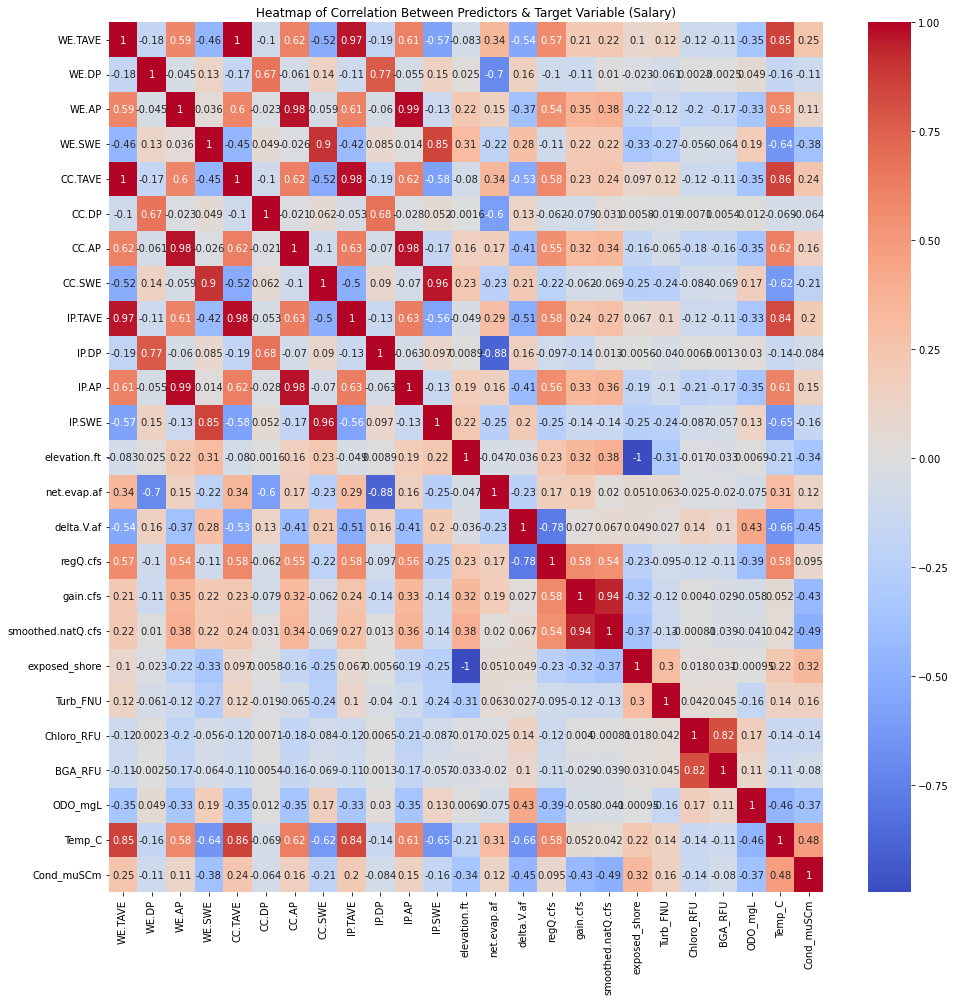

In [37]:
# set up figure size
fig, ax = plt.subplots(figsize=(16, 16))

# set up correlation matrix
corr = final_df.corr()

sns.heatmap(corr, cmap = 'coolwarm', annot = True)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Predictors & Target Variable (Salary)");

plt.show()

In [38]:
roll_mean = final_df['Turb_FNU'].rolling(window=365, center=False).mean()
roll_std = final_df['Turb_FNU'].rolling(window=365, center=False).std()

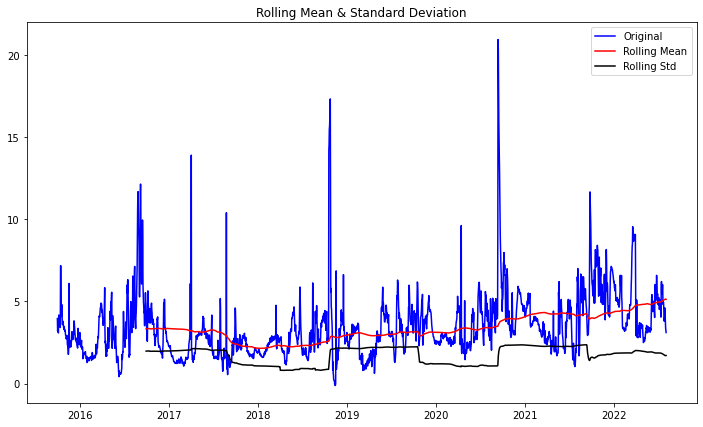

In [39]:
# Plot rolling statistics
fig = plt.figure(figsize=(12,7))
plt.plot(final_df['Turb_FNU'], color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [40]:
fsm = RandomForestRegressor(n_estimators=100, max_depth=100, random_state=42)

In [41]:
# create train-test split for FSM
cutoff = round(final_df.shape[0]*0.2)
X_test = final_df.drop(['Turb_FNU'], axis=1)[:cutoff]
X_train = final_df.drop(['Turb_FNU'], axis=1)[cutoff:]
y_test = final_df['Turb_FNU'][:cutoff]
y_train = final_df['Turb_FNU'][cutoff:]

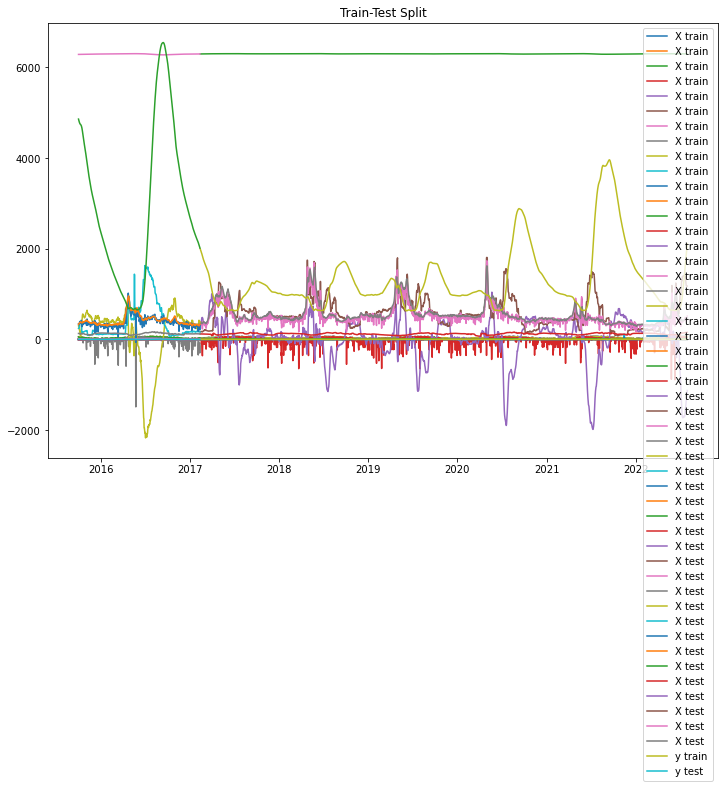

In [42]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_train, label='X train')
ax.plot(X_test, label='X test')
ax.plot(y_train, label='y train')
ax.plot(y_test, label='y test')
ax.set_title('Train-Test Split');
plt.legend();

In [43]:
final_df.index = pd.to_datetime(final_df.index)

In [44]:
# from sklearn.metrics import mean_squared_error
# import statsmodels.api as sm
# ts_fsm = TimeSeriesSplit(n_splits = 4)
# rmse = []
# for train_index, test_index in ts_fsm.split(final_df.Turb_FNU):
#     cv_train, cv_test = final_df.Turb_FNU.iloc[train_index], final_df.Turb_FNU.iloc[test_index]
    
#     arima = sm.tsa.ARIMA(cv_train, (2,0,2)).fit(disp=False)
    
#     predictions = arima.predict(cv_test.index.values[0], cv_test.index.values[-1])
#     true_values = cv_test.values
#     rmse.append(sqrt(mean_squared_error(true_values, predictions)))
    
# print("RMSE: {}".format(np.mean(rmse)))

In [45]:
fsm.fit(X_train, y_train)

RandomForestRegressor(max_depth=100, random_state=42)

In [46]:
fsm_pred = fsm.predict(X_test)

In [47]:
fsm_pred = pd.DataFrame(fsm_pred)
fsm_pred.set_index(X_test.index, inplace=True)

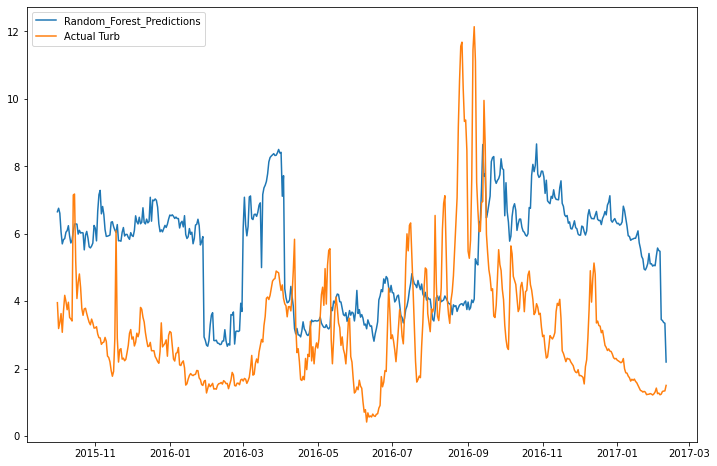

In [48]:
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(fsm_pred,label='Random_Forest_Predictions')
plt.plot(y_test,label='Actual Turb')
plt.legend(loc="upper left")
plt.show()

In [49]:
fsm.score(X_test, y_test)

-2.0546693414923527

In [50]:
final_df = pd.DataFrame(final_df)
final_df

,WE.TAVE,WE.DP,WE.AP,WE.SWE,CC.TAVE,CC.DP,CC.AP,CC.SWE,IP.TAVE,IP.DP,...,regQ.cfs,gain.cfs,smoothed.natQ.cfs,exposed_shore,Turb_FNU,Chloro_RFU,BGA_RFU,ODO_mgL,Temp_C,Cond_muSCm
date,,,,,,,,,,,,,,,,,,,,,
2015-10-01,54.0,0.1,0.1,0.0,56.0,0.1,0.1,0.0,57.0,0.0,...,244.000000,341.889379,335.882328,4860.324029,3.956154,0.373125,0.013333,8.465625,11.975563,132.769792
2015-10-02,46.0,0.1,0.2,0.0,47.0,0.8,0.9,0.0,50.0,0.1,...,248.000000,343.032424,338.607610,4838.088862,3.189579,0.409368,0.019053,7.160632,12.138179,131.143158
2015-10-03,42.0,0.0,0.2,0.0,44.0,0.0,0.9,0.0,43.0,0.0,...,249.000000,323.164907,345.015633,4817.476359,3.369271,0.411979,0.005104,7.582917,12.135823,131.415625
2015-10-04,42.0,0.0,0.2,0.0,42.0,0.1,1.0,0.0,42.0,0.0,...,264.000000,333.358530,356.919502,4798.860101,3.632353,0.488471,0.096471,8.818471,12.134565,133.509412
2015-10-05,50.0,0.0,0.2,0.0,50.0,0.1,1.1,0.0,46.0,0.0,...,314.000000,363.931624,362.039401,4782.091636,3.077765,0.646404,0.249326,8.000225,12.336517,127.920225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-28,67.0,0.0,39.6,0.0,68.0,0.0,22.7,0.0,69.0,0.0,...,1182.187500,407.214395,442.453386,1888.767601,4.219896,0.428229,0.047188,6.822292,19.556458,156.690625
2022-07-29,66.0,0.0,39.6,0.0,67.0,0.0,22.7,0.0,66.0,0.0,...,1181.875000,429.932614,451.777714,1946.610070,3.899583,0.438333,0.048646,6.774479,19.535104,157.709375
2022-07-30,69.0,0.0,39.6,0.0,70.0,0.0,22.7,0.0,66.0,0.0,...,1183.750000,454.622985,465.082169,2003.672122,3.379583,0.413229,0.047708,6.654688,19.576562,158.085417


In [70]:
#creating the train and validation set
train = final_df[:int(0.8*(len(final_df)))]
valid = final_df[int(0.8*(len(final_df))):]

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train, freq='D')
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(train, steps=len(valid))

KeyError: -1

# hana_ml, no liscense

In [ ]:
# import hana_ml
# from hana_ml import dataframe
# conn = dataframe.ConnectionContext('host', 'port', 'username', 'password')

In [ ]:
# from hana_ml.algorithms.pal.tsa.vector_arima import VectorARIMA

# vectorArima1 = VectorARIMA(order=(-1, 2, -1), model_type = 'VARMA', search_method='grid_search', output_fitted=True, max_p=5, max_q=5)
# vectorArima1.fit(data=train)

# print(vectorArima1.model_.collect())
# print(vectorArima1.fitted_.collect())
# print(vectorArima1.model_.collect()['CONTENT_VALUE'][3])

# Linear Regression

In [ ]:
numeric_pipeline = Pipeline([('numnorm', StandardScaler())])

ct = ColumnTransformer([("numpipe", numeric_pipeline, X_train.columns)])

steps = [('preprocess', ct), ('model', LinearRegression(positive=True))]

model_lr = Pipeline(steps)

model_lr.fit(X_train, y_train)

In [ ]:
model_lr.score(X_test, y_test)

# SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

numeric_pipeline = Pipeline([('numnorm', StandardScaler())])

ct = ColumnTransformer([("numpipe", numeric_pipeline, X_train.columns)])

model_pipe1 = Pipeline([('preprocess', ct),('model', SARIMAX(endog=y_test))])

model_pipe1.fit(X_train,y_train)
print('train score: {}'.format(model_pipe1.score(X_train,y_train)))
print('test score: {}'.format(model_pipe1.score(X_test,y_test)))
model_pipe1

In [ ]:
model_pipe1.score(X_test,y_test)

In [ ]:
sari = SARIMAX(y_train, X_train)

In [ ]:
sari.fit(X_test)

# ML prelim

In [ ]:
from tsextract.feature_extraction.extract import build_features, build_features_forecast
from tsextract.domain.statistics import mean, median, std

features_request = {
    "window": [365],
    "window_statistic": [365, mean], 
    "difference_statistic": [365, 1, std], 
}

build_df = build_features(final_df.Turb_FNU, features_request, target_lag=9, include_tzero=True)

In [ ]:
X_train.shape[1]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout


model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(x=X_train, y=y_train, batch_size=365, epochs=500, verbose=1)

In [ ]:
# this is weird, are these plots even mine?


from tsextract.plots.eval import actualPred, get_lag_corr, scatter

actualPred(y_test, model.predict(X_test).reshape(-1))
scatter(y_test, model.predict(X_test).reshape(-1))
get_lag_corr(y_test, model.predict(X_test).reshape(-1), num_lags=400)

In [ ]:
model.score(X_test,y_test)

# SVM

In [53]:
from sklearn import svm
from sklearn.svm import LinearSVR

In [56]:
numeric_pipeline = Pipeline([('numnorm', StandardScaler())])

ct = ColumnTransformer([("numpipe", numeric_pipeline, X_train.columns)])

# build pipeline 
svm_steps = [('preprocess', ct),
            ('model', svm.SVR())]

svm_pipeline = Pipeline(svm_steps)

# define parameters in the grid
svm_grid = {
            'model__kernel': ['rbf', 'linear', 'sigmoid'],
            'model__C': [0.1, 1, 10]
           }  

# get best R2 score from grid search
svm_model = GridSearchCV(estimator = svm_pipeline,
                         param_grid = svm_grid,
                         scoring = 'r2')


# fit and give me the best params
svm_model.fit(X_train, y_train)
display(svm_model.best_params_)
print("Best CV Score:", round(svm_model.best_score_,5))

{'model__C': 1, 'model__kernel': 'rbf'}

Best CV Score: -0.35233


# VAR

In [68]:
#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=X_train, freq='D')
model_fit = model.fit()

In [72]:
# make prediction on validation
prediction = model_fit.forecast(X_test, steps=365)

KeyError: -1

In [66]:
# numeric_pipeline = Pipeline([('numnorm', StandardScaler())])

# ct = ColumnTransformer([("numpipe", numeric_pipeline, X_train.columns)])

# var_steps = [('preprocess', ct),
#             ('model', VAR(endog=X_train, freq='D'))]

# var_pipeline = Pipeline(var_steps)

# # define parameters in the grid
# var_grid = {
#             'model__kernel': ['rbf', 'linear', 'sigmoid'],
#             'model__frequency': [0.1, 1, 10]
#            }  

# # get best R2 score from grid search
# var_model = GridSearchCV(estimator = var_pipeline,
#                          param_grid = var_grid,
#                          scoring = 'r2')


# # fit and give me the best params
# var_pipeline.fit(X_train, y_train)
# display(var_pipeline.best_params_)
# print("Best CV Score:", round(var_model.best_score_,5))

TypeError: only integer scalar arrays can be converted to a scalar index

# Decompose turbidity

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(final_df.Turb_FNU, model="additive")
decompose_data.plot();

### is seasonality every other year here?

https://analyticsindiamag.com/hands-on-tutorial-on-vector-autoregressionvar-for-time-series-modeling/

In [ ]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(final_df.Turb_FNU, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

In [ ]:
var = VAR(train)

In [ ]:
x= var.select_order()
x.summary()

In [ ]:
results = var.fit(3)
#We can check the summary of the model by.
results.summary()

In [ ]:
results.plot();

# use the above to forecast on the test set

In [ ]:
ipe_turbid = pd.read_csv("data/daily_mean_data_HFF/IPE Turbidity Daily Mean IY 2022-08-10.csv")
ipe_turbid.drop(['Year.count','Min','Median','Max','Q1','Q3','StDev'], axis=1, inplace=True)
ipe_turbid.set_index(['X'], inplace=True)
ipe_turbid

In [ ]:
ipe_turbid['Mean'].plot(figsize=(16,6))

In [ ]:
data_transform = pd.Series(np.log(ipe_turbid['Mean']))
rolmean = data_transform.rolling(window=4, center=False).mean()
data_minus_rolmean = data_transform - rolmean

In [ ]:
fig = plt.figure(figsize=(11, 7))
orig = plt.plot(data_transform, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
minus = plt.plot(data_minus_rolmean, color='green', label='Minus')
plt.legend(loc='best')
plt.title('Original, Rolling Mean, Minus')
plt.show(block=False)

In [ ]:
diff = data_transform.diff().dropna()
dftest = adfuller(diff)
display_df(dftest)

In [ ]:
rolmean.plot()

In [ ]:
ipe_chloro = pd.read_csv('data/daily_mean_data_HFF/IPE Chloro Daily Mean IY 2022-08-10.csv')
ipe_chloro.drop(['Year.count'], axis=1, inplace=True)
ipe_chloro.set_index(['X'], inplace=True)
ipe_chloro

In [ ]:
ipe_chloro.plot(figsize=(16,6))

In [ ]:
ipe_cond = pd.read_csv('data/daily_mean_data_HFF/IPE Cond Daily Mean IY 2022-08-10.csv')
ipe_cond.drop(['Year.count'], axis=1, inplace=True)
ipe_cond.set_index(['X'], inplace=True)
ipe_cond

In [ ]:
ipe_cond.plot(figsize=(16,6))

In [ ]:
ipe_odo = pd.read_csv('data/daily_mean_data_HFF/IPE ODO Daily Mean IY 2022-08-10.csv')
ipe_odo.drop(['Year.count','Min','Median','Max','Q1','Q3','StDev'], axis=1, inplace=True)
ipe_odo.set_index(['X'], inplace=True)
ipe_odo

In [ ]:
ipe_odo['Mean'].plot(figsize=(16,6))

In [ ]:
ipe_temp = pd.read_csv("data/daily_mean_data_HFF/IPE Temp_C Daily Mean IY 2022-08-10.csv")
ipe_temp

In [ ]:
ipe_temp.plot(figsize=(16,6))

In [ ]:
ipe_bga = pd.read_csv('data/daily_mean_data_HFF/IPE BGA Daily Mean IY 2022-08-10.csv')
ipe_bga

In [ ]:
ipe_bga.plot(figsize=(16,6))